<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/Enesemble_for_poultry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import copy
!pip install timm
from timm.loss import LabelSmoothingCrossEntropy
import timm
from tqdm import tqdm
import time
import os
from torchvision import transforms
from torch import nn, optim


In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/Models_for_Enesemble_Learning/efficientNetB7_model.h5')
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Models_for_Enesemble_Learning/mobileNetV3_model.h5')
model3 = tf.keras.models.load_model('/content/drive/MyDrive/Models_for_Enesemble_Learning/vgg19_model.h5')

In [ ]:
# for CUDA/gpu
import torch
from torchvision import transforms
from PIL import Image
from torch import nn, optim


# Load the saved model
checkpoint = torch.load('/content/drive/MyDrive/Models_for_Enesemble_Learning/Copy of swin_model.pth')

# Reinitialize the model architecture
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(checkpoint['classes']))
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Load the classes
classes = checkpoint['classes']

# Set model to evaluation mode
model.eval()

# Define transformations for the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
])

# Function to predict class of an image
def predict_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return predicted.item(), classes[predicted.item()]

# Example usage:
# image_path = "/content/drive/MyDrive/Colab Notebooks/DIP_Swin_Transfromer/input/DIP/DIP_Splited_Aug_Dataset/test/healthy/healthy.1001.jpg"
# predicted_class_index, predicted_class = predict_image(image_path)
# print("Predicted Class:", predicted_class)
# classes_dict['swin'] = predicted_class



Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [ ]:
# for CUDA/GPU
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
from torch import nn

# Load the model
checkpoint = torch.load('/content/drive/MyDrive/Models_for_Enesemble_Learning/Copy of vit_model.pth')

# Define the model architecture
model_ft = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Modify the classifier to match the expected architecture
n_inputs = model_ft.classifier.in_features  # Get the number of input features to the classifier
classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(checkpoint['classes']))  # Use the number of classes from the loaded checkpoint
)
model_ft.classifier = classifier

# Load the state dictionary
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

# Load other necessary variables
history = checkpoint['history']
classes = checkpoint['classes']

# Create image processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Set model to evaluation mode
model_ft.eval()

# Function to predict image class
def predict_image2(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)  # Move inputs to GPU if available
    outputs = model_ft(**inputs)
    _, predicted = torch.max(outputs.logits, 1)
    return classes[predicted]

# Example usage
# image_path = "/content/drive/MyDrive/Colab Notebooks/DIP_Swin_Transfromer/input/DIP/DIP_Splited_Aug_Dataset/test/healthy/healthy.1001.jpg"
# predicted_class = predict_image(image_path)
# print("Predicted class:", predicted_class)
# classes_dict['vision'] = predicted_class

# print(classes_dict)



1/1 [==============================] - 0s 21ms/step


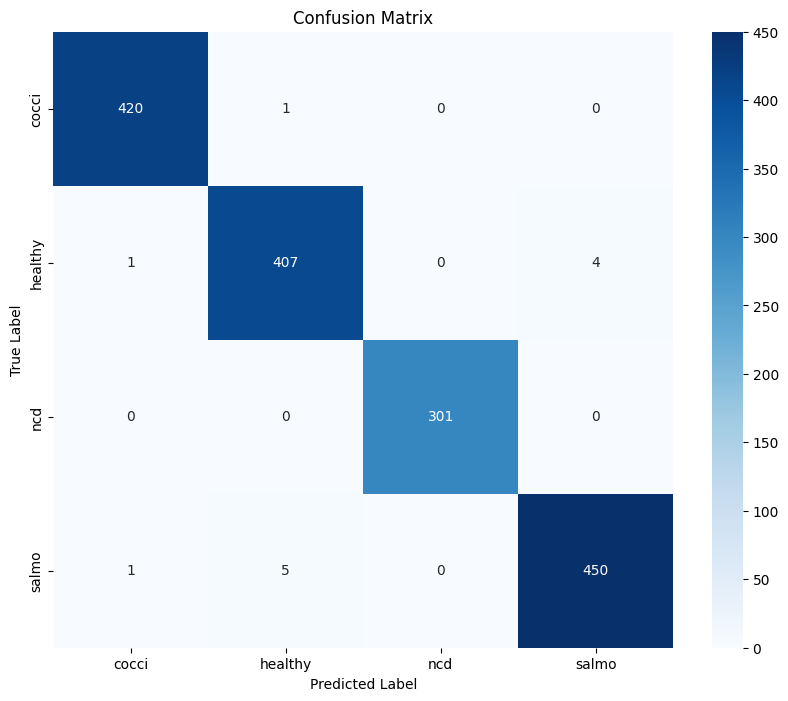

Accuracy: 0.9924528301886792
Precision: 0.9924538654315438
Recall: 0.9924528301886792
F1 Score: 0.992451230827112


In [ ]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the test dataset
test_folder = "/content/drive/MyDrive/Colab Notebooks/DIP_Swin_Transfromer/input/DIP/DIP_Splited_Aug_Dataset/test"

# Get a list of class folders within the test folder
class_folders = os.listdir(test_folder)

# Sort class folders alphabetically
class_folders.sort()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Initialize dictionaries to map class names to numerical labels
class_to_label = {class_name: i for i, class_name in enumerate(class_folders)}
label_to_class = {i: class_name for i, class_name in enumerate(class_folders)}

# Iterate through each class folder
for class_folder in class_folders:
    # Get the true label from the class folder name
    true_label = class_to_label[class_folder]
    class_folder_path = os.path.join(test_folder, class_folder)

    # Get a list of image filenames in the class folder
    image_files = os.listdir(class_folder_path)

    # Iterate through each image in the class folder
    for image_file in image_files:
        # Append the true label for this image
        true_labels.append(true_label)

        # Load the image
        image_path = os.path.join(class_folder_path, image_file)

        # Make predictions using each model
        predictions = []

        # Model 1 - TensorFlow model
        image_tf = tf.keras.preprocessing.image.load_img(image_path, target_size=(240, 240))
        image_tf = tf.keras.preprocessing.image.img_to_array(image_tf)
        image_tf = np.expand_dims(image_tf, axis=0)
        prediction_tf = model1.predict(image_tf)
        predictions.append(prediction_tf.argmax(axis=1)[0])

        # Model 2 - TensorFlow model
        image_tf = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        image_tf = tf.keras.preprocessing.image.img_to_array(image_tf)
        image_tf = np.expand_dims(image_tf, axis=0)
        prediction_tf = model2.predict(image_tf)
        predictions.append(prediction_tf.argmax(axis=1)[0])

        # Model 3 - TensorFlow model
        image_tf = tf.keras.preprocessing.image.load_img(image_path, target_size=(240, 240))
        image_tf = tf.keras.preprocessing.image.img_to_array(image_tf)
        image_tf = np.expand_dims(image_tf, axis=0)
        prediction_tf = model3.predict(image_tf)
        predictions.append(prediction_tf.argmax(axis=1)[0])

        # Model 4 - PyTorch model (Swin Transformer)
        predicted_class_index, _ = predict_image(image_path)
        predictions.append(predicted_class_index)

        # Model 5 - PyTorch model (ViT)
        prediction_vision = predict_image2(image_path)
        predictions.append(classes.index(prediction_vision))

        # Perform majority voting
        aggregated_prediction = np.bincount(predictions).argmax()
        predicted_labels.append(aggregated_prediction)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with class names and color-coding
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_folders, yticklabels=class_folders)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_folders)

# Print classification report
print(report)


              precision    recall  f1-score   support

       cocci       1.00      1.00      1.00       421
     healthy       0.99      0.99      0.99       412
         ncd       1.00      1.00      1.00       301
       salmo       0.99      0.99      0.99       456

    accuracy                           0.99      1590
   macro avg       0.99      0.99      0.99      1590
weighted avg       0.99      0.99      0.99      1590

